In [4]:
import torch
import torch.nn.functional as F
import torch.nn as nn

In [2]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Scaled Dot-Product Attention 구현
    """
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

    if mask is not None:
        scores = scores.masked_fill(mask == 1, -1e9)

    attention_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attention_weights, V)

    return output, attention_weights

batch_size, seq_len_q, seq_len_k, d_k, d_v = 2, 5, 5, 4, 6
Q_test = torch.randn(batch_size, seq_len_q, d_k)
K_test = torch.randn(batch_size, seq_len_k, d_k)
V_test = torch.randn(batch_size, seq_len_k, d_v)

output, attn_weights = scaled_dot_product_attention(Q_test, K_test, V_test)
print('ouput shape:', output.shape)
print('attention_weights shape:', attn_weights.shape)

ouput shape: torch.Size([2, 5, 6])
attention_weights shape: torch.Size([2, 5, 5])


In [ ]:
# pseudo-code
attn_out, _ self.mha_enc(X, X, X)
Z_1 = X + attn_out
Z_1 = self.layernorm1(Z_1)

In [7]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "헤드 수로 나누어떨어져야 합니다."

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Q, K, V를 만들기 위한 선형 변환
        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.W_O = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)

        Q = self.W_Q(Q)
        K = self.W_K(K)
        V = self.W_V(V)

        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask == 1, -1e9)
        attn_weights = nn.Softmax(dim=-1)(scores)
        out = torch.matmul(attn_weights, V)

        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        out = self.W_O(out)

        return out, attn_weights

d_model = 16
num_heads = 4
batch_size, seq_len = 2, 5

sample_input = torch.randn(batch_size, seq_len, d_model)
mha = MultiHeadAttention(d_model, num_heads)
output, attn_weights = mha(sample_input, sample_input, sample_input)
print('MHA output shape:', output.shape)
print('MHA attn_weights shape:', attn_weights.shape)

MHA output shape: torch.Size([2, 5, 16])
MHA attn_weights shape: torch.Size([2, 4, 5, 5])


In [8]:
import numpy as np
import matplotlib.pyplot as plt

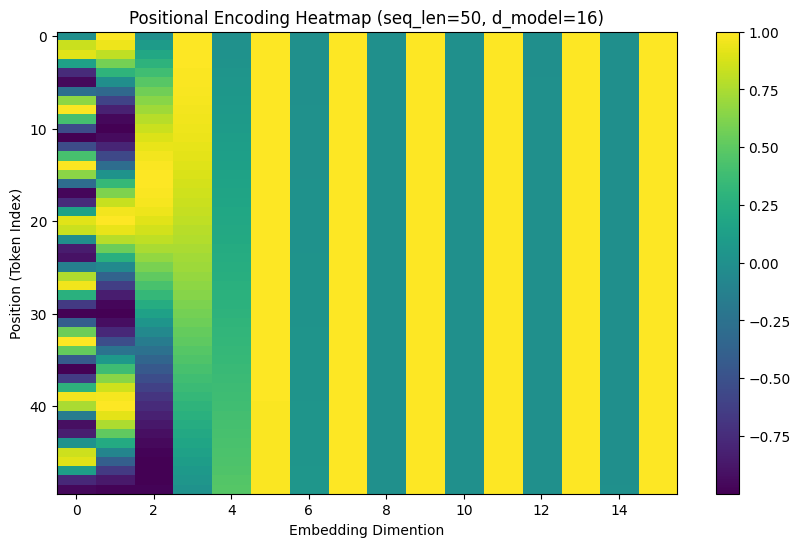

In [9]:
def positional_encoding(seq_len, d_model):
    PE = np.zeros((seq_len, d_model))
    for pos in range(seq_len):
      for i in range(0, d_model, 2):
        PE[pos, i] = np.sin(pos / (10000 ** ((2 * i)/d_model)))
        if i + 1 < d_model:
          PE[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
    return PE

seq_len = 50
d_model = 16
pe_matrix = positional_encoding(seq_len, d_model)

plt.figure(figsize=(10, 6))
plt.imshow(pe_matrix, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Positional Encoding Heatmap (seq_len=50, d_model=16)')
plt.xlabel('Embedding Dimention')
plt.ylabel('Position (Token Index)')
plt.show()

Epoch 10/50, Loss: 2.8684
Epoch 20/50, Loss: 2.6551
Epoch 30/50, Loss: 2.4393
Epoch 40/50, Loss: 2.2850
Epoch 50/50, Loss: 2.0362


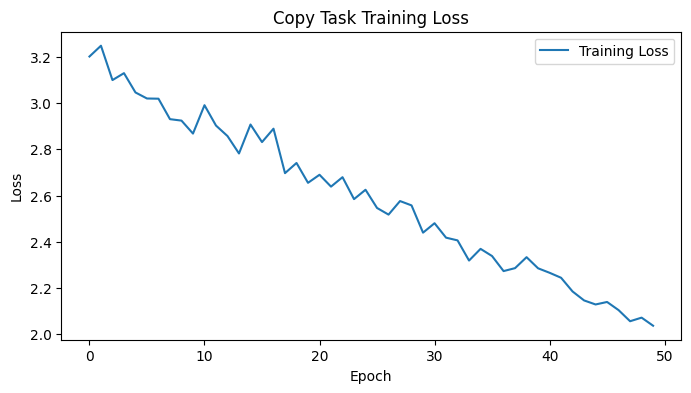

Test input (src): tensor([[15,  2, 10,  5, 17]])
Ground truth: tensor([[15,  2, 10,  5, 17]])
Model output: tensor([[ 8,  3, 10,  5,  3]])


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 간단한 (Encoder-Decoder) Transformer 예시
from typing import Optional

class SimpleTransformer(nn.Module):
    def __init__(self, d_model=16, num_heads=2, num_tokens=20):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.num_tokens = num_tokens

        # 토큰 임베딩 레이어
        self.embedding = nn.Embedding(num_tokens, d_model)

        # 인코더
        self.mha_enc = MultiHeadAttention(d_model, num_heads)
        self.ffn_enc = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.ReLU(),
            nn.Linear(d_model * 2, d_model)
        )
        self.ln_enc1 = nn.LayerNorm(d_model)
        self.ln_enc2 = nn.LayerNorm(d_model)

        # 디코더
        self.mha_dec_self = MultiHeadAttention(d_model, num_heads)
        self.mha_dec_enc = MultiHeadAttention(d_model, num_heads)
        self.ffn_dec = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.ReLU(),
            nn.Linear(d_model * 2, d_model)
        )
        self.ln_dec1 = nn.LayerNorm(d_model)
        self.ln_dec2 = nn.LayerNorm(d_model)
        self.ln_dec3 = nn.LayerNorm(d_model)

        # 마지막 출력 레이어
        self.fc_out = nn.Linear(d_model, num_tokens)

    def forward(self, src_seq, tgt_seq,
                src_mask: Optional[torch.Tensor] = None,
                tgt_mask: Optional[torch.Tensor] = None):
        # src_seq, tgt_seq: [batch_size, seq_len]

        # (1) 임베딩
        src_embed = self.embedding(src_seq)
        tgt_embed = self.embedding(tgt_seq)

        # (2) 인코더 Self-Attention
        enc_out, _ = self.mha_enc(src_embed, src_embed, src_embed, mask=src_mask)
        enc_out = self.ln_enc1(src_embed + enc_out)

        # (2-1) 인코더 FFN
        ffn_enc_out = self.ffn_enc(enc_out)
        enc_out = self.ln_enc2(enc_out + ffn_enc_out)

        # (3) 디코더 Self-Attention (미래 토큰 마스킹)
        dec_out, _ = self.mha_dec_self(tgt_embed, tgt_embed, tgt_embed, mask=tgt_mask)
        dec_out = self.ln_dec1(tgt_embed + dec_out)

        # (3-1) 디코더 Enc-Dec Attention (인코더 출력 참조)
        dec_out2, _ = self.mha_dec_enc(dec_out, enc_out, enc_out)
        dec_out2 = self.ln_dec2(dec_out + dec_out2)

        # (3-2) 디코더 FFN
        ffn_dec_out = self.ffn_dec(dec_out2)
        dec_out3 = self.ln_dec3(dec_out2 + ffn_dec_out)

        # (4) 최종 출력 (다음 단어 예측 확률)
        logits = self.fc_out(dec_out3)  # [B, seq_len, num_tokens]

        return logits

# Copy Task 데이터: src_seq = tgt_seq
def generate_copy_data(batch_size=32, seq_len=5, num_tokens=20):
    src = torch.randint(low=0, high=num_tokens, size=(batch_size, seq_len))
    tgt = src.clone()
    return src, tgt

# 하이퍼파라미터
d_model = 16
num_heads = 2
num_tokens = 20
seq_len = 5
batch_size = 32
epochs = 50

model = SimpleTransformer(d_model=d_model, num_heads=num_heads, num_tokens=num_tokens)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_history = []
model.train()

for epoch in range(1, epochs+1):
    src_batch, tgt_batch = generate_copy_data(batch_size, seq_len, num_tokens)
    logits = model(src_batch, tgt_batch)

    loss = criterion(logits.view(-1, num_tokens), tgt_batch.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

# (추가) Loss 시각화
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Copy Task Training Loss')
plt.legend()
plt.show()

# (추가) 테스트 예시
model.eval()
with torch.no_grad():
    test_src, test_tgt = generate_copy_data(batch_size=1, seq_len=5, num_tokens=num_tokens)
    test_logits = model(test_src, test_tgt)
    pred_tokens = test_logits.argmax(dim=-1)

print("Test input (src):", test_src)
print("Ground truth:", test_tgt)
print("Model output:", pred_tokens)

# 결과 해석:
# - Loss가 점차 감소 → 모델이 점점 "복사" 능력 습득
# - pred_tokens == test_tgt 유사하면 Copy Task 학습이 된 것
# - 실제 NLP 태스크(번역 등)는 훨씬 복잡한 전처리, 마스킹, 토크나이징이 필요